# Your first FEM solver- poisson equation solver

- [x] isoparametric element(mesh)
- [x] dirichlet bc
- [x] elemen loop
- [x] matrix/vector assemble
- [x] 1d/2d poisson equation

Author: Yang Bai @ M3 Group

Date  : 2022.01.23

QQ group: 628204857

## Poisson equation

$-\Delta\phi=f$ or in 1d case: $-\frac{\partial^{2}\phi}{\partial x^{2}}=f$

Boundary conditions:

$\phi(x=x_{1})=y_{1}$ and $\phi(x=x_{2})=y_{2}$

The analytical solution in 1D case can be read as follows:

$\phi(x)=-\frac{f}{2}x^{2}+ax+b$, with $a=\frac{y_{1}-y_{2}}{x_{1}-x_{2}}+\frac{f}{2}(x_{1}+x_{2})$ and $b=y_{1}-ax_{1}+\frac{f}{2}x_{1}^{2}$

# isoparametric mesh

$\int_{\Omega}f(x,y,z)dxdydz=\int_{\Omega}f(x,y,z)d\xi d\eta d\zeta J$, with $J=\mathrm{det}(\frac{\partial\mathbf{x}}{\partial\mathbf{\xi}})$

In 1D case, the jacobian matrix looks like: $J=\frac{\partial x}{\partial\xi}$.

In 2D case, it should be:
$\mathbf{J}=\begin{bmatrix}
\frac{\partial x}{\partial\xi} & \frac{\partial y}{\partial\xi} \\
\frac{\partial x}{\partial\eta} & \frac{\partial y}{\partial\eta}
\end{bmatrix}$

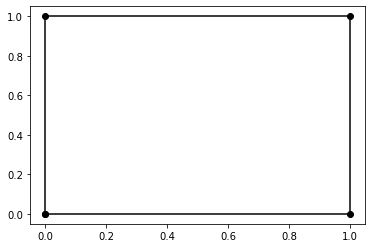

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x=np.asarray([0.0,1.0,1.0,0.0,0.0])
y=np.asarray([0.0,0.0,1.0,1.0,0.0])

plt.plot(x,y,'k-o')

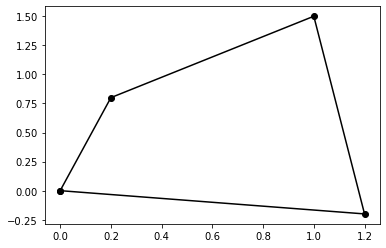

In [2]:
x=np.asarray([0.0,1.2,1.0,0.2,0.0])
y=np.asarray([0.0,-0.2,1.5,0.8,0.0])

plt.plot(x,y,'k-o')

For isoparametric mesh, one can define $\xi,\eta,\zeta\in\{-1,1\}$, then we can do the maping between $(x,y,z)$ and $(\xi,\eta,\zeta)$

[[ 1.         -0.57735027]
 [ 1.          0.57735027]]


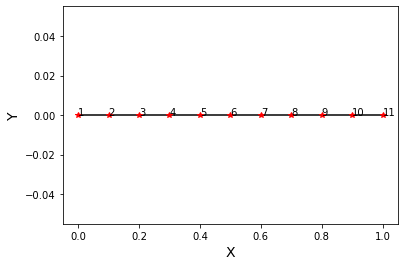

In [3]:
from FEToy.mesh.lagrange1dmesh import mesh1d
from FEToy.fe.shapefun import shape1d
from FEToy.fe.gaussrule import gausspoint1d

mymesh=mesh1d(nx=10,meshtype='edge2')
mymesh.createmesh()
mymesh.plotmesh(withnode=True,withnodeid=True)

gpoints=gausspoint1d(ngp=2)
gpoints.creategausspoint()
print(gpoints.gpcoords)

shp=shape1d(meshtype='edge2')
shp.update()

$\phi(x)=-\frac{f}{2}x^{2}+ax+b$, with $a=\frac{y_{1}-y_{2}}{x_{1}-x_{2}}+\frac{f}{2}(x_{1}+x_{2})$ and $b=y_{1}-ax_{1}+\frac{f}{2}x_{1}^{2}$

In [4]:
# Here are your parameters
f=200.0
x1=0.0;y1=0.5 # left
x2=1.0;y2=5.0 # right

def Analytical(x):
    a=(y1-y2)/(x1-x2)+0.5*f*(x1+x2)
    b=y1-a*x1+0.5*f*x1*x1
    return -0.5*f*x*x+a*x+b

The K matrix and the right hand side vector can be defined as follows:

$K=\int_{\Omega}\nabla N^{J}\nabla N^{I}dV$, $F=\int_{\Omega}fN^{I}dV$

where $I$ and $J$ are the I-th and J-th node of the current element, respectively. $N$ and $\nabla N$ represent the shape function value and its derivatives, respectively. 

In [5]:
nDofs=mymesh.nodes*1 # total degrees of freedom
K=np.zeros((nDofs,nDofs)) # Your K matrix
F=np.zeros(nDofs)         # Your RHS

# do element loop
for e in range(mymesh.elements):
    elconn=mymesh.elementconn[e,:]  # local element connectivity
    nodes=mymesh.nodecoords[elconn] # node coordinates of local element
    # now we can do the integration
    for gp in range(gpoints.ngp):
        xi=gpoints.gpcoords[gp,1] # 1->xi, 2->eta
        w =gpoints.gpcoords[gp,0] # weight
        
        shp_val,shp_grad,j=shp.calc(xi,nodes) # j->mapping from x->xi
        JxW=j*w # the weight times the determinate of jacobian transformation
        
        # now we can calculate the F term
        for i in range(mymesh.nodesperelement*1):
            iInd=elconn[i]
            # assemble to global F
            F[iInd]+=f*shp_val[i]*JxW
            # now we can calculate the K matrix
            for j in range(mymesh.nodesperelement*1):
                jInd=elconn[j]
                K[iInd,jInd]+=shp_grad[j]*shp_grad[i]*JxW
#
#print(K)
#print(F)

In [6]:
# Now we should apply our boundary conditions
iInd=mymesh.bcnodeids['left']
K[iInd,iInd]+=1.0e16 # here we use the penalty method, 1.0e16 is the 'large' number for penalty
F[iInd]+=y1*1.0e16

iInd=mymesh.bcnodeids['right']
K[iInd,iInd]+=1.0e16
F[iInd]+=y2*1.0e16

#print(K)

# now we solve K*u=F by u=K\F
phi=np.linalg.solve(K,F)
#print(phi)

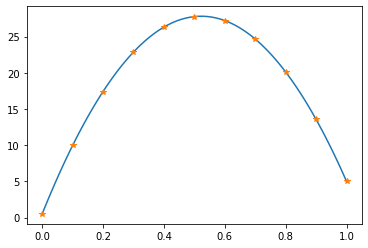

In [7]:
x=np.linspace(x1,x2,100)
sol=Analytical(x)

plt.plot(x,sol,label='analytical')
plt.plot(mymesh.nodecoords,phi,'*',label='numerical')

In [8]:
sum=0.0
for i in range(nDofs):
    sum+=(phi[i]-Analytical(mymesh.nodecoords[i]))**2

print('L2 error is: %g'%(np.sqrt(sum)))

L2 error is: 7.53331e-14


save result to result.jpg


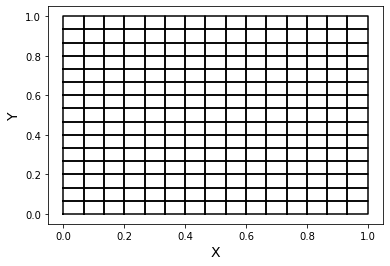

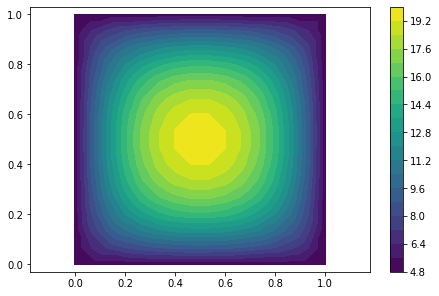

In [9]:
from FEToy.mesh.lagrange2dmesh import mesh2d
from FEToy.fe.gaussrule import gausspoint2d
from FEToy.fe.shapefun import shape2d
from FEToy.postprocess.PlotResult import Plot2D

mymesh=mesh2d(nx=15,ny=15,meshtype='quad4')
mymesh.createmesh()
mymesh.plotmesh()

gpoints=gausspoint2d(ngp=2)
gpoints.creategausspoint()

shp=shape2d(meshtype='quad4')
shp.update()

nDofs=mymesh.nodes*1
K=np.zeros((nDofs,nDofs))
F=np.zeros(nDofs)

# element loop
for e in range(mymesh.elements):
    elconn=mymesh.elementconn[e,:]
    nodes=mymesh.nodecoords[elconn,:]
    # do integration
    for gp in range(gpoints.ngp2):
        xi =gpoints.gpcoords[gp,1]
        eta=gpoints.gpcoords[gp,2]
        w  =gpoints.gpcoords[gp,0]
        
        shp_val,shp_grad,j=shp.calc(xi,eta,nodes[:,0],nodes[:,1]) # xi,eta,x,y
        JxW=j*w
        for i in range(mymesh.nodesperelement):
            iInd=elconn[i]
            F[iInd]+=f*shp_val[i]*JxW
            for j in range(mymesh.nodesperelement):
                jInd=elconn[j]
                K[iInd,jInd]+=(shp_grad[j,0]*shp_grad[i,0]+shp_grad[j,1]*shp_grad[i,1])*JxW
####
# Appyl boundary conditions
iInd=mymesh.bcnodeids['left']
K[iInd,iInd]+=1.0e16
F[iInd]+=y2*1.0e16

iInd=mymesh.bcnodeids['right']
K[iInd,iInd]+=1.0e16
F[iInd]+=y2*1.0e16

iInd=mymesh.bcnodeids['bottom']
K[iInd,iInd]+=1.0e16
F[iInd]+=y2*1.0e16

iInd=mymesh.bcnodeids['top']
K[iInd,iInd]+=1.0e16
F[iInd]+=y2*1.0e16

### solve the equaiton
phi=np.linalg.solve(K,F)

### plot result
Plot2D.Contour2D(mymesh,phi,savefig=True)